### The widening valley loss landscape

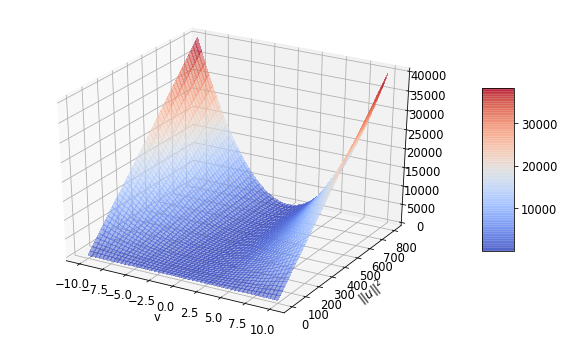

In [ ]:
# visualize the widening valley loss landscape
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

plt.rcParams["figure.figsize"] = (10,6)
plt.rc('font', size=10)
plt.rc('axes', titlesize=10) 
plt.rc('axes', labelsize=11.5)
plt.rc('xtick', labelsize=11.5) 
plt.rc('ytick', labelsize=11.5) 
plt.rc('legend', fontsize=10) 
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

uline = np.linspace(0, 800, 1000)
vline = np.linspace(-10, 10, 1000)
u, v = np.meshgrid(uline, vline)
Loss = u*v**2/2
surf = ax.plot_surface(v, u, Loss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.5)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('v')
ax.set_ylabel('$\|\|u\|\|^2$')
#ax.set_zlabel('L(u,v)')
plt.show()

### Simulate and visualize perturbations of MPGD



x_0:  0.9892800715211807


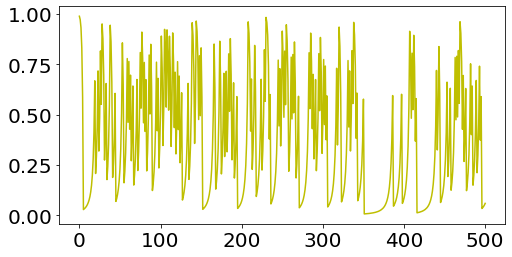

sign of v_0:  1.0


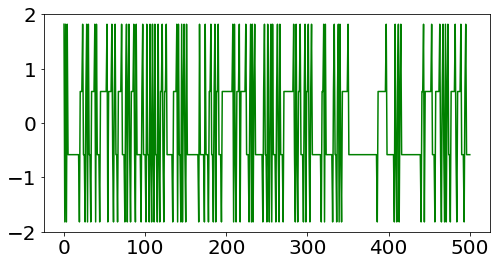

In [ ]:
# helper functions for implementing the perturbations used in MPGD (see Section 3 of the paper for full details)
from scipy.optimize import fsolve
from scipy.special import gamma as Gamma

# define the Thaler map
def Thaler_map(x, gamma):
  return ((x**(1-gamma) + (1+x)**(1-gamma) - 1)**(1/(1-gamma))) % 1

# define the chi_j 
def chi_func(x, x_star, p, seed):
  np.random.seed(seed)
  if x <= x_star:
    return 1.0
  else: 
    return 2*np.random.binomial(1,p,1)[0] - 1

# define v
def v_func(x, x_star, eta, gamma):
  alpha = 1/gamma
  if x <= x_star:
    return eta* ((1-2**(gamma-1))**(-gamma)) * ( (alpha**alpha)*(1-gamma)*Gamma(1-alpha)*np.cos(alpha*np.pi/2)/(2**(1-gamma)-1) )**(-gamma)
  else:
    return (eta* ((1-2**(gamma-1))**(-gamma)) * ( (alpha**alpha)*(1-gamma)*Gamma(1-alpha)*np.cos(alpha*np.pi/2)/(2**(1-gamma)-1) )**(-gamma))/(1-2**(1-gamma))

# define the observables v^{(k)} 
def obs_v(x_0, p, T, gamma, eta=1.0, seed=0):
  y = x_0
  def func(x, gamma=gamma):
   return x**(1-gamma) + (1+x)**(1-gamma) - 2
  x_star =  fsolve(func, (0.01))[0]
  chi_i = chi_func(x=x_0, x_star=x_star, p=p, seed=seed) 
  v_0 = chi_i*v_func(y, x_star=x_star, eta=eta, gamma=gamma)
  v_list = []
  v_list.append(v_0)

  for i in range(T):
    y = Thaler_map(y, gamma=gamma)
    chi_i = chi_i * chi_func(x=y, x_star=x_star, p=p, seed=seed)
    v_new = v_func(x = y, x_star=x_star, eta=eta, gamma=gamma)
    v = chi_i * v_new
    v_list.append(v)
  return v_list

#####################################
#choose gamma, beta, T, and seed
gamma = 0.6
beta = 0.1
p = 0.5*(1+beta)
T = 500
seed = 123
######################################

# define initial conditions following the paper
def init_data(gamma, seed=0):
  np.random.seed(seed)
  x = np.random.uniform()
  for i in range(10000):
    x = Thaler_map(x, gamma=gamma)
  x_0 = x
  return x_0

print('x_0: ', init_data(gamma=gamma, seed=seed))

# iterating the Thaler map 
thaler_iters = []
x = init_data(gamma=gamma, seed=seed)
thaler_iters.append(x)
for i in range(T):
  x = Thaler_map(x, gamma=gamma)
  thaler_iters.append(x)

# visualize the iterates of the Thaler map
plt.rcParams["figure.figsize"] = (8,4)
plt.rc('font', size=10)
plt.rc('axes', titlesize=10) 
plt.rc('axes', labelsize=20) 
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('legend', fontsize=20)

plt.plot(thaler_iters, '-y')
#plt.title('dynamics of Thaler iterates')
plt.show()

# plot of the v^n
v_list = obs_v(init_data(gamma=gamma, seed=seed), p=p, T=T, gamma=gamma, seed=seed)
print('sign of v_0: ', np.sign(v_list[0]))
plt.plot(v_list, '-g')
#plt.title('dynamics of observables v')
plt.show()

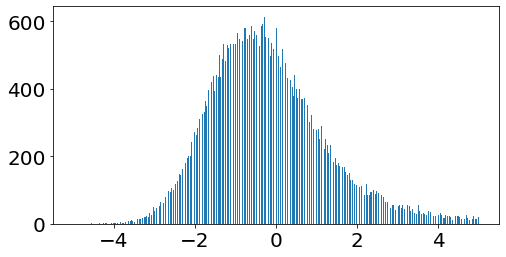

In [ ]:
# simulate the Birkhoff sum (k=1000 iterations) 
gamma = 0.60
HIST_BINS = np.linspace(-5, 5, 500)
sim1 = np.array([(1/(1001**gamma))*np.sum(obs_v(init_data(gamma=gamma, seed=seed+123*i), p=p, gamma=gamma, T=1000)) for i in range(50000)])
plt.hist(sim1, HIST_BINS)
plt.show()

### Gradient descent algorithms 
- option 0: vanilla gradient descent
- option 1: gradient descent with Gaussian perturbations
- option 2: MPGD 

In [ ]:
# implement various GD schemes: vanilla GD (baseline), GD with Gaussian perturbations, MPGD
def gd(option, mu, sigma, gamma=0.0, beta=0.5, eta=0.01, n_iter=5000, seed=2222):
  np.random.seed(seed)
  D = 5
  d = 10

  u = np.random.uniform(d)*D
  v = 0.0

  if option == 0: #no perturbations
    sigma0 = 0.0
    mu0 = 0.0
  elif option == 1: #Gaussian perturbations
    sigma0 = sigma
    mu0 = mu
  elif option == 2: #ours
    sigma0 = sigma*(eta**gamma)
    mu0 = mu*(eta**gamma)
    p = 0.5*(1+beta) 

    #following the paper
    x_0 = init_data(gamma, seed=seed)
    x_1 = init_data(gamma, seed=seed+123)
    x_2 = init_data(gamma, seed=seed+1234)

    v_list1 = obs_v(x_0, p=p, T=n_iter, gamma=gamma, seed=12+seed)
    v_list2 = obs_v(x_1, p=p, T=n_iter, gamma=gamma, seed=12+(seed+123))
    v_list3 = obs_v(x_2, p=p, T=n_iter, gamma=gamma, seed=12+(seed+1234))
  else:
    print('invalid option!')

  trace_hessian_list = []
  norm_list = []
  v_list = []
  loss = []

  for i in range(n_iter):
      if option == 0:
        u = u - eta * (u * v**2) 
        v = v - eta * (v * np.linalg.norm(u)**2)
      elif option == 1:
        u = u - eta * (u * v**2) + sigma0 * np.random.normal(d) - mu0 * np.random.normal(1) * u
        v = v - eta * (v * np.linalg.norm(u)**2) + sigma0 * np.random.normal(1) - mu0 * np.random.normal(1) * u
      elif option == 2:
        u = u - eta * (u * v**2) + sigma0*(v_list1[i]) - mu0 * v_list3[i] * u
        v = v - eta * (v * np.linalg.norm(u)**2) + sigma0 * (v_list2[i]) - mu0 * v_list3[i] * u
      else:
        print('invalid option!')
        
      trace_hessian_list.append(d*v**2 + np.linalg.norm(u)**2)
      norm_list.append(np.linalg.norm(u)**2)
      v_list.append(v)
      loss.append((v**2)*np.linalg.norm(u)**2/2)

  print('final trace of loss Hessian: ',  d*v**2 + np.linalg.norm(u)**2)

  return trace_hessian_list, norm_list, v_list, loss

### Visualize the GD dynamics in the loss landscape 

In [ ]:
eta = 0.01
sigma = 0.05
mu = 0.02 
n_iter = 2000
seed = 2222

trace_hessian_list0, norm_list0, v_list0, loss0 = gd(0, mu, sigma, eta=eta, n_iter=n_iter, seed=seed)
trace_hessian_list1, norm_list1, v_list1, loss1 = gd(1, mu, sigma, eta=eta, n_iter=n_iter, seed=seed)
trace_hessian_list2, norm_list2, v_list2, loss2 = gd(2, mu, sigma, gamma=0.6, eta=eta, n_iter=n_iter, seed=seed)
trace_hessian_list3, norm_list3, v_list3, loss3 = gd(2, mu, sigma, gamma=0.7, eta=eta, n_iter=n_iter, seed=seed)
trace_hessian_list4, norm_list4, v_list4, loss4 = gd(2, mu, sigma, gamma=0.8, eta=eta, n_iter=n_iter, seed=seed)

final trace of loss Hessian:  298.45989668428706
final trace of loss Hessian:  202.31617723267416
final trace of loss Hessian:  158.532060248704
final trace of loss Hessian:  58.990984039741384
final trace of loss Hessian:  103.92285730262132


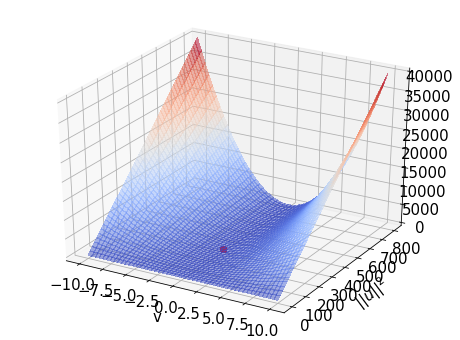

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["figure.figsize"] = (8,6)

plt.rc('font', size=10)
plt.rc('axes', titlesize=10) 
plt.rc('axes', labelsize=15) 
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('legend', fontsize=10) 
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

uline = np.linspace(0, 800, 1000)
vline = np.linspace(-10, 10, 1000)
u, v = np.meshgrid(uline, vline)
Loss = u*v**2/2
plt.plot(v_list0, norm_list0, loss0, '-ro')
surf = ax.plot_surface(v, u, Loss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.5)

#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('v')
ax.set_ylabel('$\|\|u\|\|^2$')
#ax.set_zlabel('L(u,v)')
plt.show()

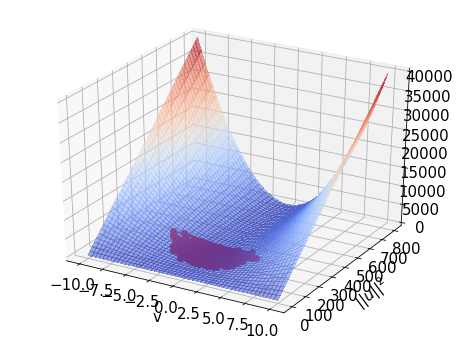

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["figure.figsize"] = (8,6)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

uline = np.linspace(0, 800, 1000)
vline = np.linspace(-10, 10, 1000)
u, v = np.meshgrid(uline, vline)
Loss = u*v**2/2
plt.plot(v_list1, norm_list1, loss1, '-ro')
surf = ax.plot_surface(v, u, Loss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.5)

#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('v')
ax.set_ylabel('$\|\|u\|\|^2$')
#ax.set_zlabel('L(u,v)')
plt.show()

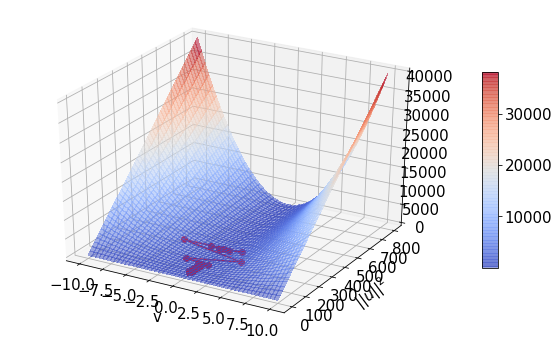

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["figure.figsize"] = (10, 6)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

uline = np.linspace(0, 800, 1000)
vline = np.linspace(-10, 10, 1000)
u, v = np.meshgrid(uline, vline)
Loss = u*v**2/2
plt.plot(v_list3, norm_list3, loss3, '-ro')
surf = ax.plot_surface(v, u, Loss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.5)

fig.colorbar(surf, shrink=0.6, aspect=12)
ax.set_xlabel('v')
ax.set_ylabel('$\|\|u\|\|^2$')
#ax.set_zlabel('L(u,v)')
plt.show()

### Visualize evolution of the trace of loss Hessian

final trace of loss Hessian:  298.45989668428706
final trace of loss Hessian:  196.39366306404577
final trace of loss Hessian:  137.35647019762615
final trace of loss Hessian:  34.749969368793515
final trace of loss Hessian:  0.245193565224637


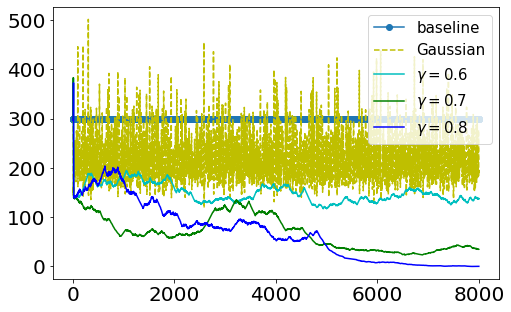

In [ ]:
eta = 0.01
sigma = 0.05
mu = 0.02
n_iter = 8000
seed = 2222

trace_hessian_list0, _, _, _ = gd(0, mu, sigma, eta=eta, n_iter=n_iter, seed=seed)
trace_hessian_list1, _, _, _ = gd(1, mu, sigma, eta=eta, n_iter=n_iter, seed=seed)
trace_hessian_list2, _, _, _ = gd(2, mu, sigma, gamma=0.6, eta=eta, n_iter=n_iter, seed=seed)
trace_hessian_list3, _, _, _ = gd(2, mu, sigma, gamma=0.7, eta=eta, n_iter=n_iter, seed=seed)
trace_hessian_list4, _, _, _ = gd(2, mu, sigma, gamma=0.8, eta=eta, n_iter=n_iter, seed=seed)

plt.rcParams["figure.figsize"] = (8,5)
plt.rc('font', size=13)
plt.rc('axes', titlesize=10) 
plt.rc('axes', labelsize=20) 
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('legend', fontsize=15) 

plt.plot(trace_hessian_list0, '-o')
plt.plot(trace_hessian_list1, '--y')
plt.plot(trace_hessian_list2, '-c')
plt.plot(trace_hessian_list3, '-g')
plt.plot(trace_hessian_list4, '-b')
#plt.title('trace of loss Hessian with ' + r'$\mu = 0.02, $' + r'$\sigma = 0.05$')
plt.legend(['baseline', 'Gaussian', r'$\gamma = 0.6$', r'$\gamma = 0.7$', r'$\gamma = 0.8$'])
plt.show()